# Testing for E1 - using all spindles, training with all data
fistly define the UUID of the experiment to use

In [54]:
experimentId="526685ff-765e-4c02-b4aa-23958be9563f"

-------------------------------------------------------

In [55]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## Override metrics to do classical F1 instead of F1*

In [56]:
def annotationPairToMetrics(annotations,detections,thresIoU=0.3):
    #get the coords
    gtCoords=zip(annotations.startInd,annotations.stopInd)
    outCoords=zip(detections.startInd,detections.stopInd)
    #calculate the iou vector
    iouVector=np.array(list(itt.starmap(getIou,itt.product(gtCoords,outCoords))))
    #reshape to a matrix
    iouMatrix=iouVector.reshape(len(annotations),len(detections))
    #binarize
    binarized=iouMatrix>thresIoU
    #calculateF1 the old way
    N=len(annotations)
    M=len(detections)
    TP=np.sum(np.max(binarized,axis=0))
    FN=N-TP
    FP=M-TP

    outF1=(2*TP)/(2*TP+FN+FP)
    recall=TP/N
    precision=TP/M

    #calculateF1*
    """ outF1=(np.sum(np.max(binarized,axis=0))+np.sum(np.max(binarized,axis=1)))/(len(annotations)+len(detections))
    recall=np.sum(np.max(binarized,axis=1))/len(annotations)
    precision=np.sum(np.max(binarized,axis=0))/len(detections) """
    return outF1,recall,precision

## load mass

In [57]:
samplerate=200  #Should rethink this

In [58]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [59]:
#consider to include this in a function
minDuration=0.3
maxDuration=5
annotations=annotations[annotations.type=='spindle']
annotations=annotations[annotations.duration>minDuration]
annotations=annotations[annotations.duration<maxDuration]
annotations=annotations.reset_index(drop=True)

In [60]:
#check with EDA results (not needed)
print(1-len(annotations)/33458)

0.005648873214178951


In [61]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,spindle,E1,0001,0001,888.327805,0.640579,200,888.968384,177666,177794
1,spindle,E1,0001,0001,905.758061,0.578094,200,906.336155,181152,181267
2,spindle,E1,0001,0001,917.731574,0.847603,200,918.579177,183546,183716
3,spindle,E1,0001,0001,922.078189,0.878845,200,922.957034,184416,184591
4,spindle,E1,0001,0001,939.055445,0.757767,200,939.813212,187811,187963


In [62]:
durations=signalsMetadata.duration
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Load experiment results

In [63]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [64]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0017, 0002, 0006]",0001,4ecbf9fd-9ea2-41f6-82ce-b88ac9b32b76,0.018639
1,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...","[0006, 0013, 0019]",0002,510c627b-7f5d-47cf-806f-77699d7869bf,0.020055
2,0001,E1,[0001],"[0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0013, 0006, 0001]",0003,81fc4ed7-34db-485d-8b93-027a1d57313e,0.021075
3,0001,E1,[0001],"[0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...","[0018, 0014, 0012]",0005,edd43941-9867-4361-a47e-36b0c1e13e96,0.018331
4,0001,E1,[0001],"[0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...","[0005, 0001, 0002]",0006,f76f3dc0-a712-49f3-842b-590c783bc6ca,0.019222
5,0001,E1,[0001],"[0001, 0002, 0003, 0010, 0011, 0012, 0013, 001...","[0005, 0006, 0009]",0007,bedbb2e2-c55d-4931-8937-6ff81b1df99a,0.019625
6,0001,E1,[0001],"[0001, 0003, 0005, 0006, 0007, 0010, 0011, 001...","[0002, 0017, 0013]",0009,d795bc85-43d1-4349-bf03-fe100d40daf9,0.017824
7,0001,E1,[0001],"[0002, 0003, 0005, 0006, 0007, 0009, 0012, 001...","[0017, 0001, 0011]",0010,02e88dcd-63b9-408e-848d-a849fc2567a1,0.017542
8,0001,E1,[0001],"[0001, 0003, 0005, 0006, 0009, 0010, 0012, 001...","[0002, 0018, 0007]",0011,a090862a-9778-4431-9c22-e5d33b1a116c,0.015442
9,0001,E1,[0001],"[0002, 0003, 0005, 0006, 0009, 0011, 0013, 001...","[0001, 0007, 0010]",0012,e7e4df1d-6250-40e8-bf6c-79a6ed4dbdab,0.016460


In [65]:
#we show the difference in class inbalance for the annotation criteria considered
experimentModels[['criteriumName','spindleTimeRate']].groupby('criteriumName').describe()

spindleTimeRate                                          \
                        count      mean       std       min       25%   
criteriumName                                                           
E1                       15.0  0.018463  0.001834  0.015442  0.017419   
E2                       15.0  0.058320  0.004520  0.052347  0.054965   
union                    15.0  0.059557  0.004579  0.053738  0.055972   

                                             
                    50%       75%       max  
criteriumName                                
E1             0.018331  0.019424  0.022439  
E2             0.056746  0.061623  0.067005  
union          0.058222  0.062711  0.068526

In [66]:
featureSelection

,window,characteristic,bandName,Times_selected
0,2,sigmaIndex,broadband,1000.0
1,2,hjortActivity,sigma,1000.0
2,1.5,sigmaIndex,broadband,1000.0
3,1,hjortActivity,sigma,1000.0
4,1,sigmaIndex,broadband,1000.0
5,2,hjortActivity,beta1,1000.0
6,2,hjortActivity,beta2,1000.0
7,1.5,hjortActivity,sigma,999.0
8,2,hjortMobility,beta1,994.0
9,2,hjortActivity,delta2,986.0


## Hyperparameter definition
this should come from a previous evaluation notebook

In [67]:
auxThres=pd.DataFrame({
    'hyperThres':[0.1, 0.2,0.3, 0.4, 0.5]
})
auxDepth=pd.DataFrame({
    'hyperDepth':[10,20,30,40, 50, 60]
})
auxMinDuration=pd.DataFrame({
    'hyperMinDuration':[0.3]
})
auxMaxDuration=pd.DataFrame({
    'hyperMaxDuration':[5]
})
auxClose=pd.DataFrame({
    'hyperClose':[0.1]
})


hyperParams=pd.merge(auxThres,auxDepth,how='cross')
hyperParams=pd.merge(hyperParams,auxMinDuration,how='cross')
hyperParams=pd.merge(hyperParams,auxMaxDuration,how='cross')
hyperParams=pd.merge(hyperParams,auxClose,how='cross')

hyperParams

,hyperThres,hyperDepth,hyperMinDuration,hyperMaxDuration,hyperClose
0,0.1,10,0.3,5,0.1
1,0.1,20,0.3,5,0.1
2,0.1,30,0.3,5,0.1
3,0.1,40,0.3,5,0.1
4,0.1,50,0.3,5,0.1
5,0.1,60,0.3,5,0.1
6,0.2,10,0.3,5,0.1
7,0.2,20,0.3,5,0.1
8,0.2,30,0.3,5,0.1
9,0.2,40,0.3,5,0.1


## Testing with E2 criterium
we test the optimal points for the prediction threshold and number of boost iterations in the different validation groups

In [68]:
experimentModels=experimentModels[experimentModels.criteriumName=='E2'].reset_index(drop=True)
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0002,E2,[0002],"[0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0017, 0002, 0006]",0001,d79e5be1-85d3-472a-a22e-6481f5b1127b,0.056746
1,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...","[0006, 0013, 0019]",0002,604deeeb-1744-4dd9-97c3-bda02d1d0d27,0.061232
2,0002,E2,[0002],"[0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0013, 0006, 0001]",0003,fd829af9-4256-476c-bc47-c5390cafe144,0.063062
3,0002,E2,[0002],"[0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...","[0018, 0014, 0012]",0005,9fc96fec-cfb6-405e-8f65-e083b96b4243,0.061716
4,0002,E2,[0002],"[0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...","[0005, 0001, 0002]",0006,e2547620-adc4-4bd4-9296-83d8386b6430,0.058705
5,0002,E2,[0002],"[0001, 0002, 0003, 0010, 0011, 0012, 0013, 001...","[0005, 0006, 0009]",0007,04b442ab-22b5-48a7-a1c0-072c20a626f0,0.061530
6,0002,E2,[0002],"[0001, 0003, 0005, 0006, 0007, 0010, 0011, 001...","[0002, 0017, 0013]",0009,0d3a86ae-0c6c-4b2b-a26b-fad23892331c,0.055908
7,0002,E2,[0002],"[0002, 0003, 0005, 0006, 0007, 0009, 0012, 001...","[0017, 0001, 0011]",0010,caf69e05-ecee-4093-b879-c3f91599d0af,0.052347
8,0002,E2,[0002],"[0001, 0003, 0005, 0006, 0009, 0010, 0012, 001...","[0002, 0018, 0007]",0011,ed3f6f59-4859-4d08-b747-68d09e29b921,0.054834
9,0002,E2,[0002],"[0002, 0003, 0005, 0006, 0009, 0011, 0013, 001...","[0001, 0007, 0010]",0012,a3abdc6c-1e79-45d2-90a9-06416c8ffa59,0.053001


In [69]:
experimentModels_N2 = experimentModels.copy()
experimentModels_N2.head()

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0002,E2,[0002],"[0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0017, 0002, 0006]",0001,d79e5be1-85d3-472a-a22e-6481f5b1127b,0.056746
1,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...","[0006, 0013, 0019]",0002,604deeeb-1744-4dd9-97c3-bda02d1d0d27,0.061232
2,0002,E2,[0002],"[0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0013, 0006, 0001]",0003,fd829af9-4256-476c-bc47-c5390cafe144,0.063062
3,0002,E2,[0002],"[0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...","[0018, 0014, 0012]",0005,9fc96fec-cfb6-405e-8f65-e083b96b4243,0.061716
4,0002,E2,[0002],"[0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...","[0005, 0001, 0002]",0006,e2547620-adc4-4bd4-9296-83d8386b6430,0.058705


In [70]:
annotationsN2=pd.read_csv(datapath+'/MASS/annotations/spindlesFilteredN2.csv')
annotationsN2['samplerate']=samplerate
annotationsN2['subjectId']=annotationsN2.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
annotationsN2['labelerId']=annotationsN2.apply(
    lambda row: str(row.labelerId).zfill(4),axis=1)
annotationsN2['stopTime']=annotationsN2.apply(
    lambda row: row.startTime+row.duration , axis=1)
annotationsN2['startInd']=annotationsN2.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
annotationsN2['stopInd']=annotationsN2.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)

In [71]:
## load hypnograms
stagesAnnotations=pd.read_csv(datapath+"\MASS\stages\stages.csv")
stagesAnnotations['samplerate']=samplerate
stagesAnnotations['subjectId']=stagesAnnotations.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
stagesAnnotations['stopTime']=stagesAnnotations.apply(
    lambda row: row.startTime+row.duration , axis=1)
stagesAnnotations['startInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
stagesAnnotations['stopInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)
stagesAnnotations.head(5)

hypnograms={}
for ind, row in signalsMetadata.iterrows():
    subjectId=row.subjectId
    thisStages=stagesAnnotations[stagesAnnotations.subjectId==subjectId]
    excerptDimension=int(row.duration*row.samplerate)
    thisHypnogram=np.ones((excerptDimension,))*np.nan
    for ind_stg, row_stg in thisStages.iterrows():
        thisHypnogram[row_stg.startInd:row_stg.stopInd]=row_stg.value
    hypnograms[subjectId]=thisHypnogram  

In [72]:
rawF1s = []
rawPrecisions = []
rawRecalls = []

rawThres = []
rawDepth = []

f1s = []
precisions = []
recalls = []

eventF1s = []
eventPrecisions = []
eventRecalls = []

checks = []

rawF1s_N2 = []
rawPrecisions_N2 = []
rawRecalls_N2 = []

f1s_N2 = []
precisions_N2 = []
recalls_N2 = []

eventF1s_N2 = []
eventPrecisions_N2 = []
eventRecalls_N2 = []

checks_N2 = []

allDetections=[]
allAnnotations=[]
allDetections_N2=[]
allAnnotations_N2=[]

thisExperimentModels = experimentModels.copy()
for ind, row in thisExperimentModels.iterrows():
    #load model
    print(ind)
    model = loadBooster(row.modelId, experimentId, datapath)
    #initialise lists
    rawF1xs=[]

    

    #iterate validation subjects
    for valSubjectId in row.val:
        print(valSubjectId)
        #Define annotations criterium
        usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
        #Load features and labels
        valFeatures=loadFeatureMatrix([valSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
        valLabels=loadLabelsVector([valSubjectId],usedAnnotations,signalsMetadata,samplerate)
        #Predict
        valDMatrix=xgb.DMatrix(data=valFeatures)
        probabilities=[]
        for i_depth, j_depth in auxDepth.iterrows():
            pred=model.predict(valDMatrix,iteration_range=(0,int(j_depth['hyperDepth'])))
            probabilities.append(pred)
        probabilities=np.array(probabilities)
        f1xs=[]

        
        for ind_hyper,row_hyper in hyperParams.iterrows():
            thisExperimentModels=experimentModels.copy()
            hyperThres=row_hyper.hyperThres
            hyperDepth=int(row_hyper.hyperDepth)
            hyperMinDuration=row_hyper.hyperMinDuration
            hyperMaxDuration=row_hyper.hyperMaxDuration
            hyperClose=row_hyper.hyperClose
            probs=probabilities[auxDepth['hyperDepth']==hyperDepth][0]
            raw=probs>=hyperThres
            #Processed labels
            processed=labelingProcess(raw,hyperClose,hyperMinDuration,samplerate)
            gtAnnotations=labelVectorToAnnotations(valLabels,samplerate)
            detections=labelVectorToAnnotations(processed,samplerate)
            detections=detections[detections.duration<hyperMaxDuration]
            #Metrics
            f,r,p=annotationPairToMetrics(gtAnnotations,detections, thresIoU=0.2)
        
            #Metric appends
            f1xs.append(f)

        rawF1xs.append(np.array(f1xs))

    #statistics of the metrics over the subjects of the validation set
    meanF1s=np.mean(np.array(rawF1xs), axis=0)
    
    optimalInd=hyperParams[meanF1s==np.max(meanF1s)].iloc[0]
    hyperParams_opt=optimalInd
    print(hyperParams_opt)
    hyperThres=hyperParams_opt['hyperThres']
    hyperDepth=int(hyperParams_opt['hyperDepth'])
    hyperMinDuration=hyperParams_opt['hyperMinDuration']
    hyperMaxDuration=hyperParams_opt['hyperMaxDuration']
    hyperClose=hyperParams_opt['hyperClose']
    
    ##
    rawThres.append(hyperThres)
    rawDepth.append(hyperDepth)


    testSubjectId=row.test
    #Define annotations criterium
    usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres
    #Raw Metrics
    rawTp=np.sum(rawLabels*testLabels)
    rawFp=np.sum(rawLabels*(1-testLabels))
    rawTn=np.sum((1-rawLabels)*(1-testLabels))
    rawFn=np.sum((1-rawLabels)*testLabels)
    #Raw appends
    rawF1s.append(2*rawTp/(2*rawTp+rawFp+rawFn))
    rawPrecisions.append(rawTp/(rawTp+rawFp) )
    rawRecalls.append(rawTp/(rawTp+rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperMinDuration,samplerate)
    #Processed metrics
    tp=np.sum(processedLabels*testLabels)
    fp=np.sum(processedLabels*(1-testLabels))
    tn=np.sum((1-processedLabels)*(1-testLabels))
    fn=np.sum((1-processedLabels)*testLabels)
    #Processed appends
    f1s.append(2*tp/(2*tp+fp+fn))
    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    processedAnnotations=processedAnnotations[processedAnnotations.duration<maxDuration]
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    f,r,p=annotationPairToMetrics(gtAnnotations,processedAnnotations, thresIoU=0.2)
    print('F1-score')
    print(f)
    #calculate metrics
    eventF1s.append(f)
    eventPrecisions.append(p)
    eventRecalls.append(r)
    
    allDetections.append(processedAnnotations)
    allAnnotations.append(gtAnnotations)
    
    #N2
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    #Define annotations criterium
    usedAnnotations=annotationsN2[annotationsN2.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load labels
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Apply mask to predictions---------------------------------->
    rawLabels=rawLabels*testN2Mask

    
    #Raw Metrics
    rawTp = np.sum(rawLabels * testLabels)
    rawFp = np.sum(rawLabels * (1 - testLabels))
    rawTn = np.sum((1 - rawLabels) * (1 - testLabels))
    rawFn = np.sum((1 - rawLabels) * testLabels)
    #Raw appends
    rawF1s_N2.append(2 * rawTp / (2 * rawTp + rawFp + rawFn))
    rawPrecisions_N2.append(rawTp / (rawTp + rawFp))
    rawRecalls_N2.append(rawTp / (rawTp + rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperMinDuration,samplerate)
    #Processed metrics
    tp = np.sum(processedLabels * testLabels)
    fp = np.sum(processedLabels * (1 - testLabels))
    tn = np.sum((1 - processedLabels) * (1 - testLabels))
    fn = np.sum((1 - processedLabels) * testLabels)
    #Processed appends
    f1s_N2.append(2 * tp / (2 * tp + fp + fn))
    precisions_N2.append(tp / (tp + fp))
    recalls_N2.append(tp / (tp + fn))

    #By-event metrics
    processedAnnotations = labelVectorToAnnotations(processedLabels, samplerate)
    gtAnnotations = labelVectorToAnnotations(testLabels, samplerate)  #<- or just filter the annotations
    f, r, p = annotationPairToMetrics(gtAnnotations, processedAnnotations, thresIoU=0.2)
    print('N2 F1-score')
    print(f)
    #calculate metrics
    eventF1s_N2.append(f)
    eventPrecisions_N2.append(p)
    eventRecalls_N2.append(r)
    
    allDetections_N2.append(processedAnnotations)
    allAnnotations_N2.append(gtAnnotations)

#include metrics in the dataframe
experimentModels['rawF1'] = rawF1s
experimentModels['rawPrecision'] = rawPrecisions
experimentModels['rawRecall'] = rawRecalls

experimentModels['f1'] = f1s
experimentModels['precision'] = precisions
experimentModels['recall'] = recalls

experimentModels['eventF1'] = eventF1s
experimentModels['eventPrecision'] = eventPrecisions
experimentModels['eventRecall'] = eventRecalls

experimentModels['Binarization_Threshold'] = rawThres
experimentModels['Boosting_Iterations'] = rawDepth

#include metrics in the N2 dataframe
experimentModels_N2['rawF1'] = rawF1s_N2
experimentModels_N2['rawPrecision'] = rawPrecisions_N2
experimentModels_N2['rawRecall'] = rawRecalls_N2

experimentModels_N2['f1'] = f1s_N2
experimentModels_N2['precision'] = precisions_N2
experimentModels_N2['recall'] = recalls_N2

experimentModels_N2['eventF1'] = eventF1s_N2
experimentModels_N2['eventPrecision'] = eventPrecisions_N2
experimentModels_N2['eventRecall'] = eventRecalls_N2

experimentModels_N2['Binarization_Threshold'] = rawThres
experimentModels_N2['Boosting_Iterations'] = rawDepth




0
0017
0002
0006
hyperThres           0.1
hyperDepth          50.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 4, dtype: float64
F1-score
0.797671617824167
N2 F1-score
0.8772555134773892
1
0006
0013
0019
hyperThres           0.4
hyperDepth          60.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 23, dtype: float64
F1-score
0.8683227082875358
N2 F1-score
0.8775273065303277
2
0013
0006
0001
hyperThres           0.2
hyperDepth          30.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 8, dtype: float64
F1-score
0.6200542005420054
N2 F1-score
0.7547918043621943
3
0018
0014
0012
hyperThres           0.5
hyperDepth          10.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 24, dtype: float64
F1-score
0.7824116047144152
N2 F1-score
0.7981481481481482
4
0005
0001
0002
hyperThres           0.2
hyperDepth          60.0
hyperMinDuration     0.3
hyperMa

### Get number and density of spindles

In [73]:
detectionDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allDetections,durations)))
annotationDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allAnnotations,durations)))
detectionNumber=list(map(lambda x: len(x),allDetections))
annotationNumber=list(map(lambda x: len(x),allAnnotations))

experimentModels['detectionNumber'] = detectionDensity
experimentModels['annotationNumber'] = annotationDensity
experimentModels['detectionDensity'] = detectionDensity
experimentModels['annotationDensity'] = annotationDensity

In [74]:
detectionDuration=list(map(lambda x: np.mean(x['duration']),allDetections))
annotationDuration=list(map(lambda x: np.mean(x['duration']),allAnnotations))
res=sst.linregress(annotationDuration,detectionDuration)
print(res)

print(np.mean(np.array(detectionDuration) - np.array(annotationDuration)))

LinregressResult(slope=0.6340138688263445, intercept=0.3805196808037231, rvalue=0.7937868189902513, pvalue=0.00041090481024672016, stderr=0.13473077993029434, intercept_stderr=0.16173290029678664)
-0.054171901548411845


LinregressResult(slope=1.0489124346967296, intercept=22.91580332527377, rvalue=0.849246494181092, pvalue=6.182576211946678e-05, stderr=0.18086932065538, intercept_stderr=34.24530023087161)
31.686476111515244


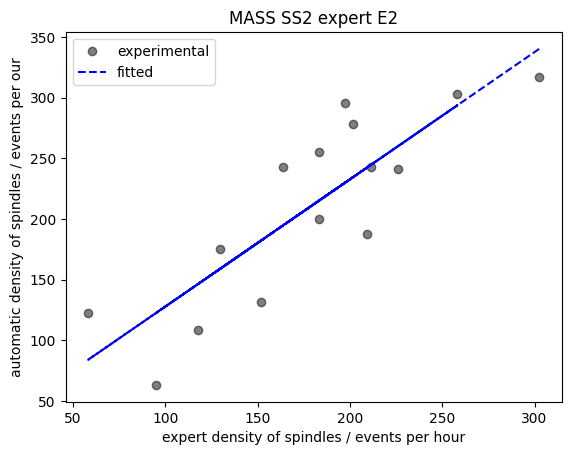

In [75]:
res=sst.linregress(annotationDensity,detectionDensity)
print(res)
print(np.mean(np.array(detectionDensity) - np.array(annotationDensity)))
plt.plot(annotationDensity,detectionDensity,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationDensity, res.intercept + res.slope*np.array(annotationDensity), 'b', linestyle='--', label='fitted')
plt.legend()
plt.title("MASS SS2 expert E2")
plt.xlabel("expert density of spindles / events per hour")
plt.ylabel("automatic density of spindles / events per our")
plt.show()

In [76]:
print(np.mean(np.array(annotationDensity)/60))
print(np.std(np.array(annotationDensity)/60))
print(np.sum(np.array(annotationNumber)))
print(np.sum(np.array(durations)))
print(60*np.sum(len(np.concatenate(allAnnotations)))/(np.sum(np.array(durations))))

2.988562738228714
1.0131317112481237
22016
563136.0
2.3457211046709854


In [77]:
timesN2=[]
for name, hypnogram in hypnograms.items():
    if name in np.array(experimentModels_N2.test):
        timesN2.append(np.sum(hypnogram==2))
timesN2=np.array(timesN2)
timesN2=timesN2/200

detectionDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allDetections_N2,timesN2)))
annotationDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allAnnotations_N2,timesN2)))
detectionNumber=list(map(lambda x: len(x),allDetections_N2))
annotationNumber=list(map(lambda x: len(x),allAnnotations_N2))

experimentModels_N2['detectionNumber'] = detectionDensity
experimentModels_N2['annotationNumber'] = annotationDensity
experimentModels_N2['detectionDensity'] = detectionDensity
experimentModels_N2['annotationDensity'] = annotationDensity

In [78]:
detectionDuration_N2=list(map(lambda x: np.mean(x['duration']),allDetections_N2))
annotationDuration_N2=list(map(lambda x: np.mean(x['duration']),allAnnotations_N2))
res=sst.linregress(annotationDuration_N2,detectionDuration_N2)
print(res)

print(np.mean(np.array(detectionDuration_N2) - np.array(annotationDuration_N2)))

LinregressResult(slope=0.7602574156614327, intercept=0.2867959574093133, rvalue=0.7512595562279275, pvalue=0.0012436586538109593, stderr=0.18524540363600617, intercept_stderr=0.2187935513134542)
0.006194648030455633


LinregressResult(slope=0.8024095005116949, intercept=85.22100166706889, rvalue=0.7817158760604292, pvalue=0.0005763648130214062, stderr=0.1775438992292448, intercept_stderr=65.96718641559883)
0.0005763648130214062
14.595340438933631


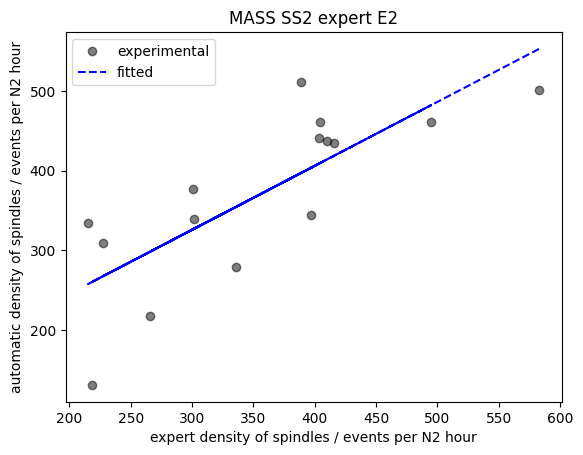

In [79]:

res=sst.linregress(annotationDensity,detectionDensity)
print(res)
print(res.pvalue)
print(np.mean(np.array(detectionDensity) - np.array(annotationDensity)))
plt.plot(annotationDensity,detectionDensity,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationDensity, res.intercept + res.slope*np.array(annotationDensity), 'b', linestyle='--', label='fitted')
plt.legend()
plt.title("MASS SS2 expert E2")
plt.xlabel("expert density of spindles / events per N2 hour")
plt.ylabel("automatic density of spindles / events per N2 hour")
plt.show()

In [80]:
print(np.mean(np.array(annotationDensity)/60))
print(np.std(np.array(annotationDensity)/60))
print(np.sum(np.array(annotationNumber)))
print(60*np.sum(len(np.concatenate(allAnnotations_N2)))/(np.sum(np.array(timesN2))))

5.957241653068061
1.6909171692228042
21601
5.999992083710273


In [81]:
dumpPickle('experimentModels_ValidationperModel_Testing_E2_IoU-0.2_temp_oldF1.pkl',experimentModels)

In [82]:
experimentModels.columns

Index(['criteriumId', 'criteriumName', 'labelerIdList', 'train', 'val', 'test',
       'modelId', 'spindleTimeRate', 'rawF1', 'rawPrecision', 'rawRecall',
       'f1', 'precision', 'recall', 'eventF1', 'eventPrecision', 'eventRecall',
       'Binarization_Threshold', 'Boosting_Iterations', 'detectionNumber',
       'annotationNumber', 'detectionDensity', 'annotationDensity'],
      dtype='object')

In [83]:
fig=px.scatter(experimentModels,x='rawF1',y='f1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['rawF1'], y=experimentModels['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

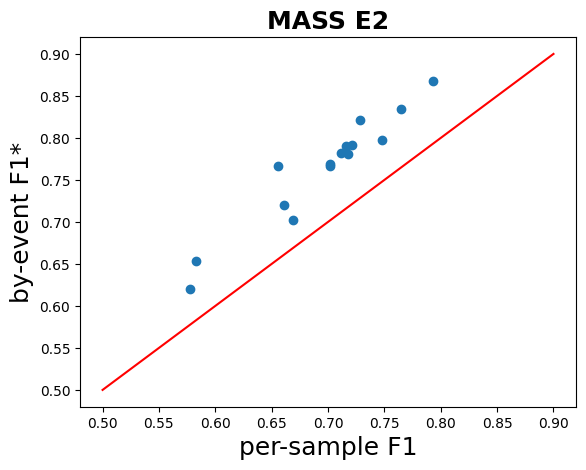

<Figure size 640x480 with 0 Axes>

In [84]:
fig=px.scatter(experimentModels,x='rawF1',y='eventF1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['rawF1'], y=experimentModels['rawF1'], name="identity", mode='lines',fill="toself")
)
ax=plt.subplot()

ax.scatter(experimentModels['rawF1'].to_numpy(), experimentModels['eventF1'].to_numpy())
ax.plot([0.5,0.9],[0.5,0.9], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("MASS E2", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
#plt.savefig('per-sample_vs_by-event_MASSE1_IoU0-2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

In [85]:
fig=px.scatter(experimentModels,x='eventF1',y='eventPrecision',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [86]:
fig=px.scatter(experimentModels,x='eventF1',y='eventRecall',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [87]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test').describe(percentiles=[0.5])

eventF1                                             eventPrecision  \
       count      mean std       min       50%       max          count   
test                                                                      
0001     1.0  0.797672 NaN  0.797672  0.797672  0.797672            1.0   
0002     1.0  0.868323 NaN  0.868323  0.868323  0.868323            1.0   
0003     1.0  0.620054 NaN  0.620054  0.620054  0.620054            1.0   
0005     1.0  0.782412 NaN  0.782412  0.782412  0.782412            1.0   
0006     1.0  0.653061 NaN  0.653061  0.653061  0.653061            1.0   
0007     1.0  0.702294 NaN  0.702294  0.702294  0.702294            1.0   
0009     1.0  0.821646 NaN  0.821646  0.821646  0.821646            1.0   
0010     1.0  0.791109 NaN  0.791109  0.791109  0.791109            1.0   
0011     1.0  0.834383 NaN  0.834383  0.834383  0.834383            1.0   
0012     1.0  0.720573 NaN  0.720573  0.720573  0.720573            1.0   
0013     1.0  0.781121 NaN  0.781121  0.781121  0.781121            1.0   
0014     1.0  0.768629 NaN  0.768629  0.768629  0.768629            1.0   
0017     1.0  0.766944 NaN  0.766944  0.766944  0.766944            1.0   
0018     1.0  0.790554 NaN  0.790554  0.790554  0.790554            1.0   
0019     1.0  0.767112 NaN  0.767112  0.767112  0.767112            1.0   

                                                 eventRecall                \
          mean std       min       50%       max       count      mean std   
test                                                                         
0001  0.779521 NaN  0.779521  0.779521  0.779521         1.0  0.816687 NaN   
0002  0.840426 NaN  0.840426  0.840426  0.840426         1.0  0.898136 NaN   
0003  0.457600 NaN  0.457600  0.457600  0.457600         1.0  0.961345 NaN   
0005  0.843597 NaN  0.843597  0.843597  0.843597         1.0  0.729501 NaN   
0006  0.816029 NaN  0.816029  0.816029  0.816029         1.0  0.544350 NaN   
0007  0.585540 NaN  0.585540  0.585540  0.585540         1.0  0.877204 NaN   
0009  0.869241 NaN  0.869241  0.869241  0.869241         1.0  0.778992 NaN   
0010  0.732950 NaN  0.732950  0.732950  0.732950         1.0  0.859294 NaN   
0011  0.800121 NaN  0.800121  0.800121  0.800121         1.0  0.871711 NaN   
0012  0.603429 NaN  0.603429  0.603429  0.603429         1.0  0.894157 NaN   
0013  0.673791 NaN  0.673791  0.673791  0.673791         1.0  0.929123 NaN   
0014  0.660251 NaN  0.660251  0.660251  0.660251         1.0  0.919576 NaN   
0017  0.797273 NaN  0.797273  0.797273  0.797273         1.0  0.738837 NaN   
0018  0.739222 NaN  0.739222  0.739222  0.739222         1.0  0.849547 NaN   
0019  0.667371 NaN  0.667371  0.667371  0.667371         1.0  0.901905 NaN   

                                    
           min       50%       max  
test                                
0001  0.816687  0.816687  0.816687  
0002  0.898136  0.898136  0.898136  
0003  0.961345  0.961345  0.961345  
0005  0.729501  0.729501  0.729501  
0006  0.544350  0.544350  0.544350  
0007  0.877204  0.877204  0.877204  
0009  0.778992  0.778992  0.778992  
0010  0.859294  0.859294  0.859294  
0011  0.871711  0.871711  0.871711  
0012  0.894157  0.894157  0.894157  
0013  0.929123  0.929123  0.929123  
0014  0.919576  0.919576  0.919576  
0017  0.738837  0.738837  0.738837  
0018  0.849547  0.849547  0.849547  
0019  0.901905  0.901905  0.901905

In [88]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean()

,test,eventF1,eventPrecision,eventRecall
0,0001,0.797672,0.779521,0.816687
1,0002,0.868323,0.840426,0.898136
2,0003,0.620054,0.457600,0.961345
3,0005,0.782412,0.843597,0.729501
4,0006,0.653061,0.816029,0.544350
5,0007,0.702294,0.585540,0.877204
6,0009,0.821646,0.869241,0.778992
7,0010,0.791109,0.732950,0.859294
8,0011,0.834383,0.800121,0.871711
9,0012,0.720573,0.603429,0.894157


In [89]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              6.668000e+54
eventF1           7.643924e-01
eventPrecision    7.244241e-01
eventRecall       8.380243e-01
dtype: float64

In [90]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().std()

C:\Users\GIB\AppData\Local\Temp\ipykernel_25412\2599554826.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.066076
eventPrecision    0.115402
eventRecall       0.105579
dtype: float64

In [91]:
auxPrecision=pd.DataFrame({
    'metric':'event precision',
    'value':experimentModels.eventPrecision,
    'event F1':experimentModels.eventF1
})

auxRecall=pd.DataFrame({
    'metric':'event recall',
    'value':experimentModels.eventRecall,
    'event F1':experimentModels.eventF1
})
visualTradeoff=pd.concat((auxPrecision,auxRecall))

In [92]:
fig=px.scatter(visualTradeoff,x='event F1',y='value',color='metric', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

## Restrict to only N2 stage

In [93]:
dumpPickle('experimentModelsTest_ValidationperModel_Testing_N2_E2_IoU-0.2_temp_oldF1.pkl',experimentModels_N2)

In [94]:
fig=px.scatter(experimentModels_N2,x='rawF1',y='f1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['rawF1'], y=experimentModels_N2['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [95]:
fig=px.scatter(experimentModels_N2,x='rawF1',y='eventF1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['rawF1'], y=experimentModels_N2['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

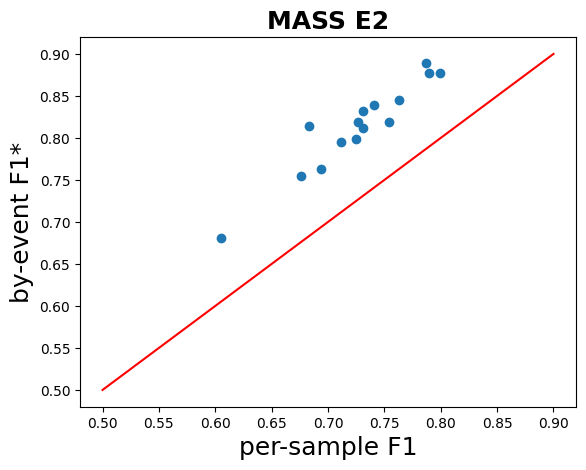

<Figure size 640x480 with 0 Axes>

In [96]:
ax=plt.subplot()

ax.scatter(experimentModels_N2['rawF1'].to_numpy(), experimentModels_N2['eventF1'].to_numpy())
ax.plot([0.5,0.9],[0.5,0.9], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("MASS E2", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
#plt.savefig('per-sample_vs_by-event_MASSE1_N2_IoU0-2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

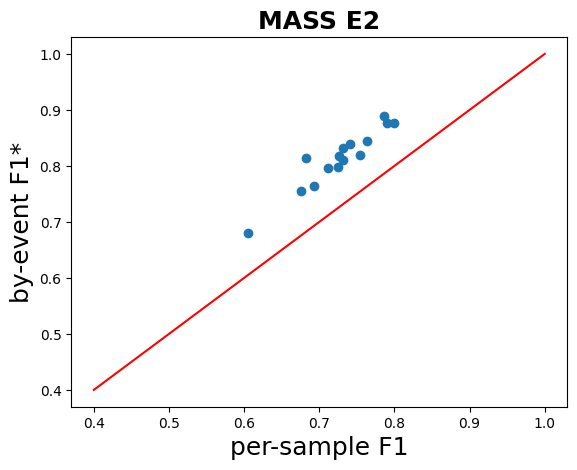

<Figure size 640x480 with 0 Axes>

In [97]:
ax=plt.subplot()

ax.scatter(experimentModels_N2['rawF1'].to_numpy(), experimentModels_N2['eventF1'].to_numpy())
ax.plot([0.4,1],[0.4,1], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("MASS E2", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
plt.savefig('per-sample_vs_by-event_MASSE2_IoU-0.2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

In [98]:
fig=px.scatter(experimentModels_N2,x='eventF1',y='eventPrecision',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [99]:
fig=px.scatter(experimentModels_N2,x='eventF1',y='eventRecall',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [100]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test').describe(percentiles=[0.5])

eventF1                                             eventPrecision  \
       count      mean std       min       50%       max          count   
test                                                                      
0001     1.0  0.877256 NaN  0.877256  0.877256  0.877256            1.0   
0002     1.0  0.877527 NaN  0.877527  0.877527  0.877527            1.0   
0003     1.0  0.754792 NaN  0.754792  0.754792  0.754792            1.0   
0005     1.0  0.798148 NaN  0.798148  0.798148  0.798148            1.0   
0006     1.0  0.680883 NaN  0.680883  0.680883  0.680883            1.0   
0007     1.0  0.818699 NaN  0.818699  0.818699  0.818699            1.0   
0009     1.0  0.832457 NaN  0.832457  0.832457  0.832457            1.0   
0010     1.0  0.888769 NaN  0.888769  0.888769  0.888769            1.0   
0011     1.0  0.844770 NaN  0.844770  0.844770  0.844770            1.0   
0012     1.0  0.839104 NaN  0.839104  0.839104  0.839104            1.0   
0013     1.0  0.818596 NaN  0.818596  0.818596  0.818596            1.0   
0014     1.0  0.795399 NaN  0.795399  0.795399  0.795399            1.0   
0017     1.0  0.814192 NaN  0.814192  0.814192  0.814192            1.0   
0018     1.0  0.811250 NaN  0.811250  0.811250  0.811250            1.0   
0019     1.0  0.763333 NaN  0.763333  0.763333  0.763333            1.0   

                                                 eventRecall                \
          mean std       min       50%       max       count      mean std   
test                                                                         
0001  0.948002 NaN  0.948002  0.948002  0.948002         1.0  0.816335 NaN   
0002  0.858182 NaN  0.858182  0.858182  0.858182         1.0  0.897765 NaN   
0003  0.620652 NaN  0.620652  0.620652  0.620652         1.0  0.962901 NaN   
0005  0.879592 NaN  0.879592  0.879592  0.879592         1.0  0.730508 NaN   
0006  0.906694 NaN  0.906694  0.906694  0.906694         1.0  0.545122 NaN   
0007  0.768711 NaN  0.768711  0.768711  0.768711         1.0  0.875641 NaN   
0009  0.896040 NaN  0.896040  0.896040  0.896040         1.0  0.777301 NaN   
0010  0.921437 NaN  0.921437  0.921437  0.921437         1.0  0.858338 NaN   
0011  0.818593 NaN  0.818593  0.818593  0.818593         1.0  0.872677 NaN   
0012  0.791699 NaN  0.791699  0.791699  0.791699         1.0  0.892548 NaN   
0013  0.735827 NaN  0.735827  0.735827  0.735827         1.0  0.922344 NaN   
0014  0.700096 NaN  0.700096  0.700096  0.700096         1.0  0.920736 NaN   
0017  0.904564 NaN  0.904564  0.904564  0.904564         1.0  0.740238 NaN   
0018  0.776360 NaN  0.776360  0.776360  0.776360         1.0  0.849423 NaN   
0019  0.661850 NaN  0.661850  0.661850  0.661850         1.0  0.901575 NaN   

                                    
           min       50%       max  
test                                
0001  0.816335  0.816335  0.816335  
0002  0.897765  0.897765  0.897765  
0003  0.962901  0.962901  0.962901  
0005  0.730508  0.730508  0.730508  
0006  0.545122  0.545122  0.545122  
0007  0.875641  0.875641  0.875641  
0009  0.777301  0.777301  0.777301  
0010  0.858338  0.858338  0.858338  
0011  0.872677  0.872677  0.872677  
0012  0.892548  0.892548  0.892548  
0013  0.922344  0.922344  0.922344  
0014  0.920736  0.920736  0.920736  
0017  0.740238  0.740238  0.740238  
0018  0.849423  0.849423  0.849423  
0019  0.901575  0.901575  0.901575

In [101]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean()

,test,eventF1,eventPrecision,eventRecall
0,0001,0.877256,0.948002,0.816335
1,0002,0.877527,0.858182,0.897765
2,0003,0.754792,0.620652,0.962901
3,0005,0.798148,0.879592,0.730508
4,0006,0.680883,0.906694,0.545122
5,0007,0.818699,0.768711,0.875641
6,0009,0.832457,0.896040,0.777301
7,0010,0.888769,0.921437,0.858338
8,0011,0.844770,0.818593,0.872677
9,0012,0.839104,0.791699,0.892548


In [102]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              6.668000e+54
eventF1           8.143450e-01
eventPrecision    8.125532e-01
eventRecall       8.375634e-01
dtype: float64

In [103]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().std()

C:\Users\GIB\AppData\Local\Temp\ipykernel_25412\292585311.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.053442
eventPrecision    0.101013
eventRecall       0.105001
dtype: float64

In [104]:
auxPrecision=pd.DataFrame({
    'metric':'event precision',
    'value':experimentModels_N2.eventPrecision,
    'event F1':experimentModels_N2.eventF1
})

auxRecall=pd.DataFrame({
    'metric':'event recall',
    'value':experimentModels_N2.eventRecall,
    'event F1':experimentModels_N2.eventF1
})
visualTradeoff=pd.concat((auxPrecision,auxRecall))

In [105]:
fig=px.scatter(visualTradeoff,x='event F1',y='value',color='metric', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

### remove outliers

In [106]:
np.setdiff1d(experimentModels_N2.test,['0006'])

array(['0001', '0002', '0003', '0005', '0007', '0009', '0010', '0011',
       '0012', '0013', '0014', '0017', '0018', '0019'], dtype=object)

In [107]:
experimentModels_N2[experimentModels_N2.test.isin(np.setdiff1d(experimentModels_N2.test,['0001','0014','0019']))][['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              1.666917e+43
eventF1           8.149323e-01
eventPrecision    8.231958e-01
eventRecall       8.270671e-01
dtype: float64

In [108]:
annotationPairToGraph(gtAnnotations,processedAnnotations)